In [1]:
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.stats import norm
%matplotlib notebook

In [2]:
window_size = 250
pre_filtering_thresh = 0.25
percent = 0.1

In [47]:
data = np.load("/home/farzad/OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/adap_default_bg_bs8_split_1_1_trial_1_5229424/adap_roi_ious_pl.pkl", allow_pickle=True)

In [48]:
plt.clf()
cls = 'Car'
for i in range(len(data[cls])):
    x = [i]*len(data[cls][i])
    y = data[cls][i]
    print(len(data[cls][i]))
    plt.scatter(x, y, s=0.5, alpha=0.1)

7677
9646
10244
12174
10527
10276
11339
11024
11699
10859
11353
11928
13161
12657


In [50]:

df[(df['iteration'] < 250)].reset_index(drop=True)

,iou_roi_pl,iou_roi_gt,pred_scores,weights,teacher_scores,class_labels,iteration
0,0.892533,0.564606,0.999532,1.000000,0.999776,1,0.0
1,0.842074,0.586626,0.997247,1.000000,0.999027,1,0.0
2,0.815203,0.632871,0.976664,1.000000,0.999443,1,0.0
3,0.756168,0.668692,0.999448,1.000000,0.999722,1,0.0
4,0.707624,0.586877,0.932739,1.000000,0.993906,1,0.0
...,...,...,...,...,...,...,...
31995,0.000000,0.000000,0.608367,0.759458,0.240542,1,249.0
31996,0.000000,0.000000,0.091069,0.900256,0.099744,2,249.0
31997,0.000000,0.000000,0.368519,0.866768,0.133232,1,249.0
31998,0.000000,0.000000,0.344773,0.447250,0.552750,2,249.0


<IPython.core.display.Javascript object>


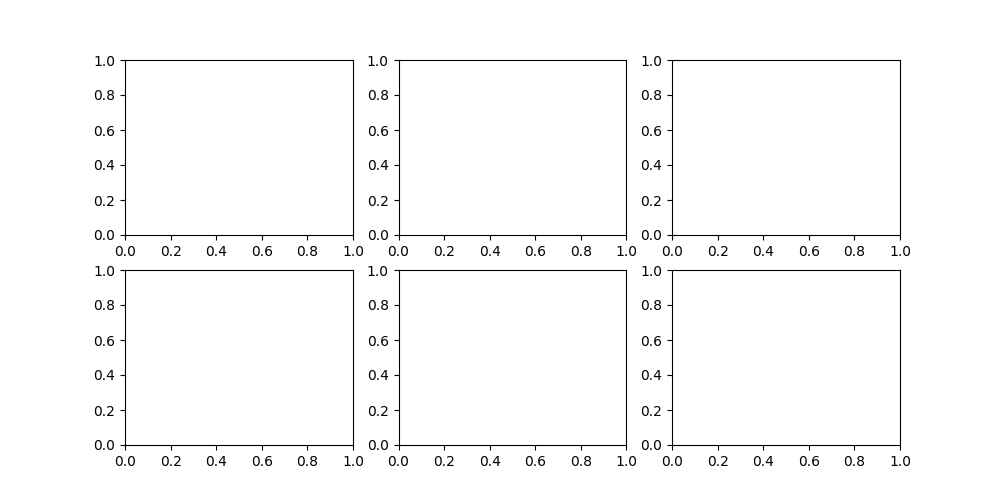

<IPython.core.display.Javascript object>


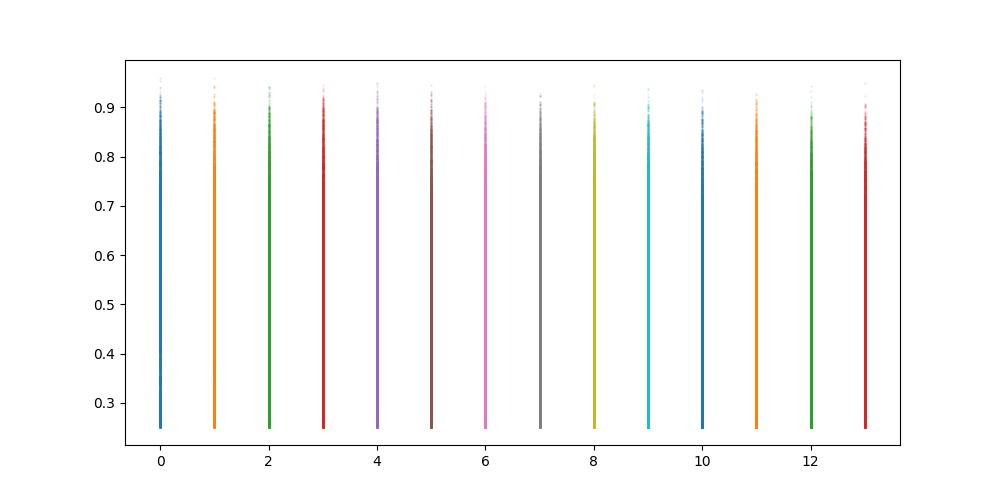

3040
5993
9663
15632
19290
22234
22284
23216
23698
23782
23602
24538
23882
24121
24084
24563
23930
23415
24618
24402
24744
24870
24796
24827
25017
25447
25107
24917
25313
25358
1486


In [43]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

classwise_threshs = [[] for _ in range(3)]
for cls in range(3):
    cls_df = df[(df['class_labels'] == cls+1) & (df['iou_roi_pl'] > pre_filtering_thresh)]
    axes[0][cls].scatter(cls_df['iteration'].astype(int), cls_df['iou_roi_pl'], s=0.1, alpha=0.5, c='orange')
    
    # Fit a Gaussian and draw densities
    max_iter = int(cls_df['iteration'].max())
    for step, i in enumerate(range(0, max_iter, window_size)):
        iter_mask = (i <= cls_df['iteration']) & (cls_df['iteration'] < i + window_size)  
        roi_ious_pl = cls_df[iter_mask]['iou_roi_pl']
        if cls == 1:
            print(len(roi_ious_pl))
        mu, sigma = norm.fit(roi_ious_pl)
        lower_bound_iou = norm.ppf(percent, loc=mu, scale=sigma)
        classwise_threshs[cls].append(lower_bound_iou)
        x = np.linspace(0, 1, 100)
        p = norm.pdf(x, mu, sigma)
        width = step * 0.1 + 0.1
        axes[1][cls].plot(x, p, 'k', linewidth=width, alpha=0.5)

In [6]:
fig.tight_layout()

In [7]:
for cls in range(3):
    axes[0][cls].plot(range(0, max_iter, window_size), classwise_threshs[cls], c='blue')